# Imports and definitions

In [1]:
local_mode = True

from collections import Counter, defaultdict
import itertools
import math
import os
import random
import re
import sys

if local_mode:
    sys.path.append("/Users/mfa/git")
else:
    sys.path.append("/home/ma629/git")

from Bio import SeqIO
from Bio.SeqUtils import MeltingTemp as mt
from matplotlib import cm
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import beta, wilcoxon, mannwhitneyu, pearsonr, spearmanr, ttest_rel, ttest_ind, kruskal, shapiro, wilcoxon
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

from ariadne import ariadne, plots, daedalus, terms
from rouls.seq_utils import read_fasta
from rouls.struct_utils import predict_structure, read_ct_file_single
from rouls.dreem_utils import get_clusters_mu_filename, get_sample_and_run, read_clusters_mu, mu_histogram_paired, plot_data_structure_roc_curve, get_data_structure_agreement

In [2]:
# Define parameters and global variables

plt.rcParams["font.family"] = "Arial"
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

if local_mode:
    analysis_dir = "/Users/mfa/o2m/rna_np_210422Rou/Analysis"
    #analysis_dir = "/Users/mfa/o2l/projects/matty/rna_np_210422Rou/Analysis"
else:
    analysis_dir = "/n/data1/hms/microbiology/rouskin/lab/projects/matty/rna_np_210422Rou/Analysis"

proj_dir = os.path.dirname(analysis_dir)
em_dir = "EM_Clustering"

dms_bases = ["A", "C"]
n_rre_clusters = 2

rre_ref_structs_name_to_dot = {
        "5-stem": ".((((((((.((((((((..(((((((((...))))))).))........((((((.....)))))).))))))))..(((((((....)))))))........((((..(((((((...)))))))..))))..(((((((((........))))))))).....)))).))))",
        "4-stem": ".((((((((.((((((((..(((((((((...))))))).))........((((((.....)))))).)))))))).((((((((......(((((...(((.....)))....)))))))))))))........(((((((((........))))))))).....)))).))))",
}

rre_ref_structs_dot_to_name = {dot: name for name, dot in rre_ref_structs_name_to_dot.items()}

rre_k_cluster_names = {1: ["5-stem"], 2: ["5-stem", "4-stem"]}

sample_clustering_runs = {("rO66v2", 2): 10}

amplicons = {
    "RRE": [(28, 202)],
    "23S": [(25, 463), (427, 871), (825, 1287), (1222, 1671), (1594, 1958)],
    "M13": [(31, 526), (525, 1033)],
    "EGFP": [(24, 473), (315, 765)],
    "rsc1218v1n660": [(29, 471), (436, 629)],
    "rsc1218v1n924": [(29, 471), (436, 892)],
}

rT66v2_stap10_target = list(range(259, 278 + 1)) + list(range(497, 520 + 1))

exclude_samples = ["rO44v2"]

In [3]:
def clean_outputs():
    # Remove existing plots and tabular outputs to start fresh.
    for ext in ["pdf", "tsv"]:
        os.system(f"rm {proj_dir}/Analysis/*{ext}")
        

def tidy_feature(feature):
    return feature.split("_")[1].strip("035")


def geo_mean(x, ignore_nan=True):
    if np.any(np.asarray(x) < 0.0):
        return np.nan
    if np.any(np.isclose(x, 0.0)):
        return 0.0
    if ignore_nan:
        mean = np.nanmean
    else:
        mean = np.mean
    return np.exp(mean(np.log(x)))
    

def read_sample_data():
    sample_file = os.path.join(proj_dir, "samples.txt")
    sample_data = pd.read_csv(sample_file, sep="\t", index_col="Sample")
    sample_data = sample_data.loc[~sample_data.index.isin(exclude_samples)]
    return sample_data


def num_to_id(num):
    sample_id = f"210422Rou_D21-{num}"
    return sample_id


def get_fasta_full_name(fasta_file, project_dir=proj_dir):
    if not fasta_file.endswith(".fasta"):
        fasta_file = fasta_file + ".fasta"
    ref_genome_dir = os.path.join(project_dir, "Ref_Genome")
    fasta_file = os.path.join(ref_genome_dir, fasta_file)
    return fasta_file


def get_dot_file_full_name(proj_dir, em_dir, sample, ref, start, end, k, c, run=None, **kwargs):
    if run is None:
        run = "best"
    run_dir = get_sample_and_run(os.path.join(proj_dir, em_dir), k, sample, ref, start, end, run=run)
    prefix = run_dir.split(os.sep)[-3]
    dot_file = os.path.join(run_dir, f"{prefix}-K{k}_Cluster{c}_expUp_0_expDown_0_pk.dot")
    return dot_file


def read_dot_file(dot_file):
    with open(dot_file) as f:
        name, seq, structure = [f.readline().strip() for i in range(3)]
    return name, seq, structure


def get_sample_mus(sample_data, sample_name):
    # Get the IDs of the samples containing the origami and the RRE.
    origami_num = sample_data.loc[sample_name, "Origami"]
    origami_id = num_to_id(origami_num)
    rre_num = sample_data.loc[sample_name, "RRE"]
    rre_id = num_to_id(rre_num)
    # Read the sequence of the origami scaffold.
    scaf_name = sample_data.loc[sample_name, "Scaffold"]
    scaf_seq_file = get_fasta_full_name(scaf_name)
    _, scaf_seq = read_fasta(scaf_seq_file)
    # Read the sequence of the RRE.
    rre_seq_file = get_fasta_full_name("RRE")
    _, rre_seq = read_fasta(rre_seq_file)
    # Read mutation rates of RRE.
    ref = "RRE"
    em_dir = "EM_Clustering"
    start, end = amplicons[ref][0]
    rre_mus = dict()
    for k in range(1, n_rre_clusters + 1):
        run = sample_clustering_runs.get((sample_name, k), "best")
        structure_order = list()
        for c in range(1, k + 1):
            dot_file = get_dot_file_full_name(proj_dir, em_dir, rre_id, ref, start, end, k, c, run=run)
            name, seq, structure = read_dot_file(dot_file)
            structure_name = rre_ref_structs_dot_to_name[structure]
            structure_order.append(structure_name)
        rre_mus_file = get_clusters_mu_filename(em_clustering_dir=os.path.join(proj_dir, em_dir), k=k, sample=rre_id, ref=ref, start=start, end=end, run=run)
        rre_mus[k] = read_clusters_mu(rre_mus_file, flatten=False, seq=rre_seq, include_gu=False)
        rre_mus[k].columns = structure_order
    # Read mutation rates of origami.
    k = 1
    origami_mus = pd.Series(dtype=np.float64)
    for amplicon in amplicons[scaf_name]:
        start, end = amplicon
        mus_file = get_clusters_mu_filename(em_clustering_dir=os.path.join(proj_dir, em_dir), k=k, sample=origami_id, ref=scaf_name, start=start, end=end, run="best")
        amplicon_mus = read_clusters_mu(mus_file, flatten=True, seq=scaf_seq, include_gu=False)
        # Average signal in overlaps between amplicons.
        if len(origami_mus) > 0:
            overlap = sorted(set(origami_mus.index) & set(amplicon_mus.index))
            if len(overlap) > 0:
                overlap_prev = origami_mus.loc[overlap]
                overlap_amp = amplicon_mus.loc[overlap]
                corr_amp_prev = np.corrcoef(overlap_amp, overlap_prev)[0,1]
                # Double check that the correlation is high, i.e. above 0.9
                corr_min = 0.9
                assert corr_amp_prev >= corr_min
                # If the correlation is high, average the two, as is common practice for replicates.
                consensus = (overlap_prev + overlap_amp) / 2
                origami_mus.loc[overlap] = consensus
            # Add the new DMS signals.
            amplicon_new = amplicon_mus[sorted(set(amplicon_mus.index) - set(overlap))]
            origami_mus = pd.concat([origami_mus, amplicon_new])
        else:
            origami_mus = amplicon_mus
    return origami_mus, rre_mus


dms_col = "DMS_signal"


def calc_corrs_means_sliding(mus1, mus2, width):
    assert mus1.shape == mus2.shape
    assert np.all(mus1.index == mus2.index)
    idx_min = np.min(mus1.index)
    idx_max = np.max(mus1.index)
    windows = [(i, i + width - 1) for i in range(idx_min, idx_max - width + 2)]
    index = pd.MultiIndex.from_tuples(windows)
    index.names = ("first", "last")
    means1 = pd.Series([np.mean(mus1.loc[wi: wf]) for wi, wf in windows], index=index)
    means2 = pd.Series([np.mean(mus2.loc[wi: wf]) for wi, wf in windows], index=index)
    corrs = pd.Series([pearsonr(mus1.loc[wi: wf], mus2.loc[wi: wf])[0] for wi, wf in windows], index=index)
    return means1, means2, corrs


def plot_corr_signal_sliding(mus1, mus2, width, plot_file):
    aspect = 3.0
    means1, means2, corrs = calc_corrs_means_sliding(mus1, mus2, width)
    corrs.to_csv(f"{plot_file}_PCC.tsv", sep="\t")
    means1.to_csv(f"{plot_file}_DMS-1.tsv", sep="\t")
    means2.to_csv(f"{plot_file}_DMS-2.tsv", sep="\t")
    centers = np.asarray((corrs.index.get_level_values("first") + corrs.index.get_level_values("last")) // 2.0, dtype=int)
    fig, ax = plt.subplots()
    ax.plot(centers, corrs)
    ax.set_ylim((-1.0, 1.0))
    ax.set_aspect(len(centers) / 2.0 / aspect)
    ax.set_xlabel("Position")
    ax.set_ylabel("PCC")
    ax.set_title(plot_file)
    plt.savefig(f"{plot_file}_PCC.pdf")
    plt.close()
    for i, means in enumerate([means1, means2], start=1):
        fig, ax = plt.subplots()
        ax.plot(centers, means)
        ax.set_ylim((0.0, 0.1))
        ax.set_aspect(len(centers) / 0.1 / aspect)
        ax.set_xlabel("Position")
        ax.set_ylabel("DMS reactivity")
        ax.set_title(plot_file)
        plt.savefig(f"{plot_file}_DMS-{i}.pdf")
        plt.close()
        fig, ax = plt.subplots()
        ax.scatter(means, corrs)
        ax.set_xlim((0.0, 0.1))
        ax.set_ylim((-1.0, 1.0))
        ax.set_aspect(0.05)
        ax.set_xlabel("DMS reactivity")
        ax.set_ylabel("Correlation")
        ax.set_title(plot_file)
        plt.savefig(f"{plot_file}_DMS-PCC-{i}.pdf")
        plt.close()
    return centers, corrs


def winsor_norm(dataset, percentile):
    pct_val = np.percentile(dataset, percentile)
    if np.isclose(pct_val, 0.0):
        raise ValueError("Percentile is zero")
    if pct_val < 0.0:
        raise ValueError("Percentile is negative")
    winsorized = np.minimum(dataset / pct_val, 1.0)
    return winsorized


def validate_23S_mus(sample_mus):
    mus_23S = sample_mus["23S"]
    mus_23S.to_csv("23S_mus_normalized.tsv", sep="\t")
    mus_23S_simon = pd.read_excel("../Validation/Simon-et-al_23S.xlsx", index_col="Position")["Combined"]
    # Adjust index of our dataset to match that of Simon et al. (which uses the full 23S rRNA)
    offset = 29
    mus_23S = mus_23S.reindex(mus_23S_simon.index - offset, copy=True)
    mus_23S.index += offset
    # Drop any index with a missing value
    keep = np.logical_not(np.logical_or(np.isnan(mus_23S), np.isnan(mus_23S_simon)))
    mus_23S_keep = mus_23S.loc[keep]
    mus_23S_simon_keep = mus_23S_simon.loc[keep]
    # Apply 90% winsorization and normalization to mus_23S so it matches the processing in Simon et al.
    winsor_pct = 90.0
    mus_23S_keep = winsor_norm(mus_23S_keep, winsor_pct)
    # Compute correlation and scatterplot
    pearson_corr = pearsonr(mus_23S_keep, mus_23S_simon_keep)
    print("PCC:", pearson_corr)
    fig, ax = plt.subplots()
    ax.scatter(mus_23S_keep, mus_23S_simon_keep)
    ax.set_aspect(1.0)
    ax.set_xlabel("23S scaffold")
    ax.set_ylabel("23S in E. coli")
    plt.savefig("23S_mus_scatter.pdf")
    plt.close()
    na_val = -2.0
    diffs_23S = (mus_23S_keep.reindex(mus_23S_simon.index) - mus_23S_simon).fillna(na_val)
    diffs_23S.to_csv("23S_diffs.tsv", sep="\t", header=False)

feature_names = ["scafDX", "stapDX", "stapSX", "stapEND", "stapSXEND", "vertex"]
markers5 = {"scaf_scafDX_3": "x", "scaf_stapDX_3": "+", "scaf_stapSX_3": "1", "scaf_vertex_3": "*", "scaf_stapEND3_0": "o", "scaf_stapSXEND3_0": "D", "scaf_scafEND5_0": "s"}
colors3 = {"scaf_scafDX_5": "#5ab4e5", "scaf_stapDX_5": "#0a72ba", "scaf_stapSX_5": "#00a875", "scaf_vertex_5": "#da6fab", "scaf_stapEND5_0": "#f15a22", "scaf_stapSXEND5_0": "#f7941d", "scaf_scafEND3_0": "#aaaaaa"}


def tidy_to_full(tidy, side):
    if "END" in tidy:
        return f"scaf_{tidy}{side}_0"
    else:
        return f"scaf_{tidy}_{side}"


def get_markers(f5, f3):
    marker = markers5[f5]
    filled_marker = marker in "*oDs"
    if filled_marker:
        color = [(1.0, 1.0, 1.0, 0.0)]
        edgecolor = colors3[f3]
    else:
        color = colors3[f3]
        edgecolor = None
    return marker, color, edgecolor

def get_feature_hex(feature):
    if str(feature).lower() == "none":
        return "#dddddd"
    return colors3[tidy_to_full(feature, "5")]


def hex_to_rgb(hex):
    assert isinstance(hex, str)
    if hex.startswith("#"):
        hex = hex[1:]
    assert len(hex) == 6
    return tuple([int(hex[i: i+2], 16) for i in range(0, 4+1, 2)])


def get_feature_rgb(feature):
    return hex_to_rgb(get_feature_hex(feature))


tidy_colors = {feat: get_feature_hex(feat) for feat in ["none"] + feature_names}


jitter_std = 0.15
jitter_max = 0.30

# Analysis and figures

In [4]:
clean_outputs()


In [5]:
# Load the sample IDs.
sample_data = read_sample_data()

# Load the DMS mutation rates.
scaf_groups = dict()
sample_mus = dict()
rre_mus = dict()
for sample in sample_data.index:
    scaffold = sample_data.loc[sample, "Scaffold"]
    if scaffold not in scaf_groups:
        scaf_groups[scaffold] = list()
    scaf_groups[scaffold].append(sample)
    sample_mus[sample], rre_mus[sample] = get_sample_mus(sample_data, sample)
rre_mus = {(k, c): pd.DataFrame.from_dict({sample: mus[k][c] for sample, mus in rre_mus.items()}) for k in range(1, n_rre_clusters + 1) for c in rre_k_cluster_names[k]}

# Load the scaffold sequences.
scaf_seqs = dict()
for seq_name in sample_data["Scaffold"]:
    if seq_name not in scaf_seqs:
        _, scaf_seqs[seq_name] = read_fasta(get_fasta_full_name(seq_name))
scaf_seqs_df = {scaf: pd.Series(list(seq), index=range(1, len(seq) + 1)) for scaf, seq in scaf_seqs.items()}

# Compute the DMS signal ratios wrt 23S RRE.
rre_standard = "23S"
rre_means = rre_mus[1, "5-stem"].mean(axis=0)
sig_ratios = rre_means / rre_means[rre_standard]

# Normalize the DMS signals on the origami using the ratios.
sample_mus = {sample: mus / sig_ratios.loc[sample] for sample, mus in sample_mus.items()}
validate_23S_mus(sample_mus)
for k, c in rre_mus:
    # Compute the correlations over RRE controls.
    rre_corr = rre_mus[k, c].corr()
    rre_corr.to_csv("RRE_corr.txt", sep="\t")
    rre_mus[k, c] /= sig_ratios
    rre_mus[k, c].to_csv(f"rre_mus_{k}-{c}.tsv", sep="\t")

# Collect all DMS signals into one dataframe.
all_mus = pd.DataFrame([
        [
            sample_data.loc[sample, "Scaffold"],
            sample,
            idx,
            mu
        ]
        for sample, mus in sample_mus.items()
        for idx, mu in mus.items()
], columns=["Scaffold", "Sample", "Position", "DMS Signal"])
all_mus

PCC: (0.7763199819219238, 2.0833511288334697e-192)


,Scaffold,Sample,Position,DMS Signal
0,23S,rPB66v1,27,0.013063
1,23S,rPB66v1,28,0.003030
2,23S,rPB66v1,32,0.001391
3,23S,rPB66v1,34,0.010748
4,23S,rPB66v1,35,0.010471
...,...,...,...,...
8914,rsc1218v1n924,rsc1218v1n924,884,0.062029
8915,rsc1218v1n924,rsc1218v1n924,885,0.078555
8916,rsc1218v1n924,rsc1218v1n924,890,0.029477
8917,rsc1218v1n924,rsc1218v1n924,891,0.047714


<ipython-input-6-bc6fac8258df>:4: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim((0.0, np.max(all_mus["DMS Signal"]) * 1.05))


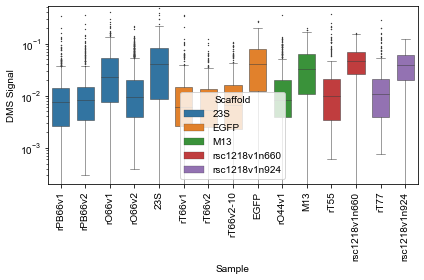

In [6]:
# Plot the DMS signals for all origamis.
sns.boxplot(data=all_mus, x="Sample", y="DMS Signal", hue="Scaffold", width=0.7, dodge=False, whis=2.0, linewidth=0.5, fliersize=0.5)
plt.yscale("log")
plt.ylim((0.0, np.max(all_mus["DMS Signal"]) * 1.05))
plt.xticks(rotation=90)
plt.tight_layout()
#plt.savefig("dms_signals_box.pdf")
#plt.close()

In [7]:
# Initialize data to collect from each origami.
origamis = dict()  # name of scaffold: names of origamis with that scaffold
scaffolds = dict()  # name of origami: name of scaffold
delta_mus_medians = dict()  # name of origami: median quotient of scaffold to origami DMS among all bases
delta_mus_p_values = dict()  # name of origami: p-value that its signal is different from scaffold (Wilcoxon signed rank test)
mus_medians_delta = dict()  # name of origami: quotient of median scaffold signal and median origami signal 
origamis_dir = os.path.join(proj_dir, "Origamis_singleXO")
scaf_chain = "A"
origami_analyze_features = ["rT55", "rT66v2", "rT77", "rO66v2", "rPB66v2"]
base_info = dict()
origami_segments = dict()
feat_col = "Feature"

# Collect data from each origami.
for scaf, group in scaf_groups.items():
    group_df = pd.DataFrame.from_dict({x: sample_mus[x] for x in group})
    
    # Plot all the origamis in the group vs each other.
    print(group_df.corr()**2)
    sns.pairplot(group_df)
    plt.savefig(f"{scaf}_group.pdf")
    plt.close()
    group_df.to_csv(f"mus_{scaf}.tsv", sep="\t")
    
    # Predict structures for the scaffold.
    output_prefix = os.path.join(analysis_dir, f"{scaf}")
    seq = scaf_seqs[scaf]
    ct_file = f"{output_prefix}.ct"
    if not os.path.isfile(ct_file):
        predict_structure(scaf, seq, sample_mus[scaf], output_prefix,
                program="Fold", normbases=0.05, overwrite=True, queue=False)
    
    # Plot a histogram of the DMS signals.
    _, pairs, unpaired, seq_ct = read_ct_file_single(ct_file, multiple=0)
    assert seq_ct == seq
    hist_file = f"{output_prefix}_hist.pdf"
    mu_histogram_paired(hist_file, sample_mus[scaf], unpaired,
            bin_width=0.001)
    
    # Plot each origami vs its scaffold.
    origamis[scaf] = [x for x in group if x != scaf]
    for origami in origamis[scaf]:
        scaffolds[origami] = scaf
        print("Analyzing origami:", origami)
        
        # Plot DMS signals of each origami vs its scaffold. 
        fig, ax = plt.subplots()
        ax.scatter(sample_mus[origami], sample_mus[scaf], s=0.5)
        ax.set_aspect("equal")
        plt.xlim((0, 0.5))
        plt.ylim((0, 0.5))
        plt.xlabel(origami)
        plt.ylabel(scaf)
        plt.savefig(f"{scaf}_vs_{origami}_scatter.pdf")
        plt.close()
        fig, ax = plt.subplots()
        origami_boxplot_data = pd.DataFrame({scaf: sample_mus[scaf], origami: sample_mus[origami]})
        data_min = 1E-4
        origami_boxplot_data[origami_boxplot_data < data_min] = data_min
        flierprops = dict(marker='o', markerfacecolor="gray", markersize=2,
                          linestyle='none', markeredgecolor="gray")
        sns.boxplot(data=np.log10(origami_boxplot_data), flierprops=flierprops, linewidth=1.0)
        ax.set_ylim((data_min/2.0, 1E0))
        ax.set_aspect(1.5)
        #ax.set_yscale("log")
        ax.set_ylabel("DMS Reactivity")
        plt.savefig(f"{scaf}_vs_{origami}_box.pdf")
        plt.close()
        
        # Plot the correlation of the DMS signals in the origami vs. the scaffold as a sliding window.
        sliding_plot = f"{scaf}_vs_{origami}_sliding"
        sliding_width = 20
        scaf_corrs_centers, scaf_corrs = plot_corr_signal_sliding(sample_mus[scaf], sample_mus[origami], sliding_width, sliding_plot)
        
        # Compute the median change in DMS signal for the origami wrt the scaffold.
        delta_mus = sample_mus[scaf] / sample_mus[origami]
        delta_mus_medians[origami] = np.nanmedian(delta_mus)
        mus_medians_delta[origami] = np.median(sample_mus[scaf]) / np.median(sample_mus[origami])
        
        # Compute the significance of the difference using Wilcoxon signed-rank test.
        w_stat, p_value = wilcoxon(sample_mus[origami], sample_mus[scaf])
        delta_mus_p_values[origami] = p_value
        if origami not in origami_analyze_features:
            # Do not analyze the feature-DMS relationship.
            continue
        
        # Get the feature feature of each base in the origami.
        origami_dir = os.path.join(origamis_dir, sample_data.loc[origami, "Directory"])
        edges, g_up, g_dn, g_ax, base_info[origami], dssr_info = ariadne.analyze_design(origami_dir, compute_bond_lengths=False, clobber=True)
        
        # Remove staples, leaving only scaffold bases.
        base_info[origami] = base_info[origami].loc[base_info[origami].loc[:, "PDB chain"] == scaf_chain]
        
        # Get all the segments in the origami.
        segments = daedalus.get_segments(base_info[origami], g_up, g_dn)
        segments["Origami"] = origami
        segments["Length"] = segments["Seg3"] - segments["Seg5"] + 1
        assert np.all(segments["Length"] > 0)
        origami_segments[origami] = segments
        
        # Adjusting the sequence is necessary for origamis for which I don't have the DAEDALUS output with the right scaffold sequence -- if all were correct then this step would be unnecessary
        base_info[origami]["Base"] = scaf_seqs_df[scaf]
        
        # Draw a secondary structure diagram.
        secondary_structure_fname = f"ss_{origami}.pdf"
        dms_min = 1e-4
        if origami == "rO66v1":
            colors = pd.Series((scaf_corrs.values + 1.0) / 2.0, index=scaf_corrs_centers)
        else:
            colors = sample_mus[origami]
            colors.loc[colors < dms_min] = dms_min
            colors = np.log10(colors)
            colors = (colors - colors.min()) / (colors.max() - colors.min())
        if not os.path.isfile(secondary_structure_fname):
            # This takes about one minute per plot.
            #FIXME plots.secondary_structure_signal(secondary_structure_fname, edges, g_up, g_dn, g_ax, base_info[origami], colors)
            pass
plt.close()

          rPB66v1   rPB66v2    rO66v1    rO66v2       23S
rPB66v1  1.000000  0.160968  0.027462  0.026228  0.044470
rPB66v2  0.160968  1.000000  0.007313  0.043889  0.017336
rO66v1   0.027462  0.007313  1.000000  0.218568  0.468759
rO66v2   0.026228  0.043889  0.218568  1.000000  0.166472
23S      0.044470  0.017336  0.468759  0.166472  1.000000
Analyzing origami: rPB66v1
Analyzing origami: rPB66v2
23s_rPB66_v2
	reading PDB file ...


/Users/mfa/mc/lib/python3.8/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Could not assign element "H5''" for Atom (name=H5'') with given element '5'
  warnings.warn(msg, PDBConstructionWarning)
/Users/mfa/mc/lib/python3.8/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Could not assign element "H2''" for Atom (name=H2'') with given element '2'
  warnings.warn(msg, PDBConstructionWarning)


	reading CanDo file ...
	annotating bases ...
	compiling all base information ...
	writing results files ...
Analyzing origami: rO66v1
Analyzing origami: rO66v2
23s_rO66_v2
	reading PDB file ...


/Users/mfa/mc/lib/python3.8/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Could not assign element "H5''" for Atom (name=H5'') with given element '5'
  warnings.warn(msg, PDBConstructionWarning)
/Users/mfa/mc/lib/python3.8/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Could not assign element "H2''" for Atom (name=H2'') with given element '2'
  warnings.warn(msg, PDBConstructionWarning)


	reading CanDo file ...
	annotating bases ...
	compiling all base information ...
	writing results files ...
             rT66v1    rT66v2  rT66v2-10      EGFP
rT66v1     1.000000  0.028183   0.009564  0.002849
rT66v2     0.028183  1.000000   0.473478  0.041546
rT66v2-10  0.009564  0.473478   1.000000  0.041910
EGFP       0.002849  0.041546   0.041910  1.000000
Analyzing origami: rT66v1
Analyzing origami: rT66v2
EGFP_rTet66_v2
	reading PDB file ...


/Users/mfa/mc/lib/python3.8/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Could not assign element "H5''" for Atom (name=H5'') with given element '5'
  warnings.warn(msg, PDBConstructionWarning)
/Users/mfa/mc/lib/python3.8/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Could not assign element "H2''" for Atom (name=H2'') with given element '2'
  warnings.warn(msg, PDBConstructionWarning)


	reading CanDo file ...
	annotating bases ...
	compiling all base information ...
	writing results files ...
Analyzing origami: rT66v2-10
          rO44v1       M13
rO44v1  1.000000  0.005033
M13     0.005033  1.000000
Analyzing origami: rO44v1
                   rT55  rsc1218v1n660
rT55           1.000000       0.032701
rsc1218v1n660  0.032701       1.000000
Analyzing origami: rT55
rT55_rsc_v2
	reading PDB file ...


/Users/mfa/mc/lib/python3.8/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Could not assign element "H5''" for Atom (name=H5'') with given element '5'
  warnings.warn(msg, PDBConstructionWarning)
/Users/mfa/mc/lib/python3.8/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Could not assign element "H2''" for Atom (name=H2'') with given element '2'
  warnings.warn(msg, PDBConstructionWarning)


	reading CanDo file ...
	annotating bases ...
	compiling all base information ...
	writing results files ...
                  rT77  rsc1218v1n924
rT77           1.00000        0.05604
rsc1218v1n924  0.05604        1.00000
Analyzing origami: rT77
rT77_rsc_v2
	reading PDB file ...


/Users/mfa/mc/lib/python3.8/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Could not assign element "H5''" for Atom (name=H5'') with given element '5'
  warnings.warn(msg, PDBConstructionWarning)
/Users/mfa/mc/lib/python3.8/site-packages/Bio/PDB/Atom.py:218: PDBConstructionWarning: Could not assign element "H2''" for Atom (name=H2'') with given element '2'
  warnings.warn(msg, PDBConstructionWarning)


	reading CanDo file ...
	annotating bases ...
	compiling all base information ...
	writing results files ...


In [8]:
f5_vals = ["scaf_stapDX_3", "scaf_stapSXEND3_0", "scaf_stapSX_3", "scaf_vertex_3", "scaf_scafDX_3", "scaf_stapEND3_0"]
f3_vals = ["scaf_scafDX_5", "scaf_stapDX_5", "scaf_stapSX_5", "scaf_stapSXEND5_0", "scaf_stapEND5_0", "scaf_vertex_5"]
base_col = "Base"
dms_min = 1e-4

In [9]:
origami_segments

{'rPB66v2':      Seg5  Seg3         Feature5           Feature3  Origami  Length
 0       1    16  scaf_scafEND5_0      scaf_stapDX_5  rPB66v2      16
 1      17    38    scaf_stapDX_3      scaf_stapDX_5  rPB66v2      22
 2      39    47    scaf_stapDX_3      scaf_vertex_5  rPB66v2       9
 3      48    60    scaf_vertex_3  scaf_stapSXEND5_0  rPB66v2      13
 4      61    68    scaf_stapSX_3    scaf_stapEND5_0  rPB66v2       8
 ..    ...   ...              ...                ...      ...     ...
 164  1931  1941    scaf_stapDX_3    scaf_stapEND5_0  rPB66v2      11
 165  1942  1952  scaf_stapEND3_0      scaf_stapDX_5  rPB66v2      11
 166  1953  1961    scaf_stapDX_3      scaf_vertex_5  rPB66v2       9
 167  1962  1974    scaf_vertex_3  scaf_stapSXEND5_0  rPB66v2      13
 168  1975  1980    scaf_stapSX_3    scaf_scafEND3_0  rPB66v2       6
 
 [169 rows x 6 columns],
 'rO66v2':      Seg5  Seg3         Feature5           Feature3 Origami  Length
 0       1    16  scaf_scafEND5_0      scaf

In [10]:
# Compile a DataFrame for each base in each origami of the upstream and downstream features and the DMS signal.
origami_segment_bases = dict()
for origami, segments in origami_segments.items():
    segment_attrs = pd.DataFrame(index=segments.index, dtype=float)
    seq = scaf_seqs[scaffolds[origami]]
    for seg in segments.index:
        start = segments.loc[seg, "Seg5"]
        end = segments.loc[seg, "Seg3"]
        seq_seg = seq[start - 1: end]
        assert len(seq_seg) > 0
        dms_seg = list()
        data = segments.loc[seg].to_dict()
        positions = list(range(start, end + 1))
        for pos in positions:
            dms = sample_mus[origami].get(pos, np.nan)
            origami_segment_bases[origami, pos] = {**data,
                    feat_col: base_info[origami].loc[pos, feat_col], dms_col: dms, base_col: seq[pos - 1]}
            dms_seg.append(dms)
        gc_content = np.mean([x in "CG" for x in seq_seg])
        # Predict melting temperature of RNA/DNA duplex
        tm = mt.Tm_NN(seq_seg, nn_table=mt.R_DNA_NN1, Na=300, saltcorr=6)
        attrs = dict()
        for base in "MAC":
            dms_seg_base = [dms if base in ["M", seq_seg[pos]] else np.nan
                    for pos, dms in enumerate(dms_seg)]
            if len(dms_seg_base) > 0:
                dms_mean = geo_mean(np.maximum(dms_seg_base, dms_min))
                attrs[f"DMS5{base}"] = dms_seg_base[0]
                attrs[f"DMS3{base}"] = dms_seg_base[-1]
            else:
                dms_mean = np.nan
                attrs[f"DMS5{base}"] = np.nan
                attrs[f"DMS3{base}"] = np.nan
            if len(dms_seg_base) > 2:
                dms_mean_interior = geo_mean(np.maximum(dms_seg_base[1: -1], dms_min))
                attrs[f"DMS5a{base}"] = dms_seg_base[1]
                attrs[f"DMS3a{base}"] = dms_seg_base[-2]
            else:
                dms_mean_interior = np.nan
                attrs[f"DMS5a{base}"] = np.nan
                attrs[f"DMS3a{base}"] = np.nan
            attrs[f"DMSall{base}"] = dms_mean
            attrs[f"DMSint{base}"] = dms_mean_interior
        attrs["GC"] = gc_content
        attrs["Tm"] = tm
        for attr, value in attrs.items():
            segment_attrs.loc[seg, attr] = value
    origami_segments[origami] = pd.concat([origami_segments[origami], segment_attrs], axis=1)
origami_segment_bases = pd.DataFrame.from_dict(origami_segment_bases, orient="index")
origami_segment_bases.to_csv("origami_segment_bases.tsv", sep="\t")
origami_segment_bases

<ipython-input-3-aad6f45894a6>:20: RuntimeWarning: Mean of empty slice
  return np.exp(mean(np.log(x)))


Seg5  Seg3         Feature5         Feature3  Origami  Length  \
rPB66v2 1       1    16  scaf_scafEND5_0    scaf_stapDX_5  rPB66v2      16   
        2       1    16  scaf_scafEND5_0    scaf_stapDX_5  rPB66v2      16   
        3       1    16  scaf_scafEND5_0    scaf_stapDX_5  rPB66v2      16   
        4       1    16  scaf_scafEND5_0    scaf_stapDX_5  rPB66v2      16   
        5       1    16  scaf_scafEND5_0    scaf_stapDX_5  rPB66v2      16   
...           ...   ...              ...              ...      ...     ...   
rT77    920   919   924    scaf_stapDX_3  scaf_scafEND3_0     rT77       6   
        921   919   924    scaf_stapDX_3  scaf_scafEND3_0     rT77       6   
        922   919   924    scaf_stapDX_3  scaf_scafEND3_0     rT77       6   
        923   919   924    scaf_stapDX_3  scaf_scafEND3_0     rT77       6   
        924   919   924    scaf_stapDX_3  scaf_scafEND3_0     rT77       6   

                     Feature  DMS_signal Base  
rPB66v2 1    scaf_scafEND5_0         NaN    G  
        2        scaf_none_0         NaN    C  
        3        scaf_none_0         NaN    C  
        4        scaf_none_0         NaN    C  
        5        scaf_none_0         NaN    T  
...                      ...         ...  ...  
rT77    920      scaf_none_0         NaN    A  
        921      scaf_none_0         NaN    T  
        922      scaf_none_0         NaN    T  
        923      scaf_none_0         NaN    T  
        924  scaf_scafEND3_0         NaN    G  

[5940 rows x 9 columns]

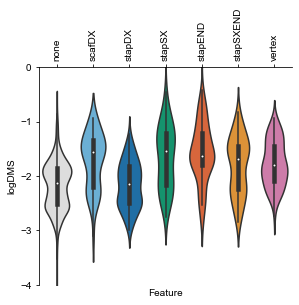

In [11]:
# Plot the distributions of DMS reactivities on each type of feature
fig, ax = plt.subplots()
origami_segment_bases["logDMS"] = np.log10(origami_segment_bases[dms_col])
origami_segment_bases["tidyFeature"] = origami_segment_bases[feat_col].apply(tidy_feature)
xlabels = ["none"] + feature_names
sns.violinplot(data=origami_segment_bases, x="tidyFeature", y="logDMS",
               order=xlabels, inner="box", palette=tidy_colors)
ax.set_ylim(-4.0, 0.0)
ax.set_yticks(np.linspace(-4.0, 0.0, 5))
ax.set_aspect(1.5)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90.0)
ax.xaxis.tick_top()
ax.set_xlabel("Feature")
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
plt.savefig("dms_by_feature.pdf")


scafDX -log10 P [0.00327954 0.04822708 0.01278718 0.39516343 0.03353886 1.26824018
 0.03161441 0.27173819 0.59934187 0.45979695]
stapDX -log10 P [0.11612269 0.53157558 0.33722034 0.23677977 2.27214652 0.29731451
 0.04637382 0.0768113  0.2685641  0.28284986]
stapSX -log10 P [7.86072261e-02 1.78963501e-01 1.47429029e-03 1.68748483e+00
 8.26877674e+00 1.38139274e+00 1.97156408e-01 1.50822911e-01
 1.95334837e-01 1.51990495e-01]
stapEND -log10 P [1.47766027 1.40908476 0.72016542 0.34147792 6.17929999 2.80543641
 1.35336096 0.09571396 0.19673505 0.15371818]
stapSXEND -log10 P [0.19877633 0.02125562 0.21267457 0.07874118 3.90963423 4.85854065
 0.80296164 0.7436194  0.07739927 0.22265602]
vertex -log10 P [0.06831229 0.88783046 0.72234942 4.30668792 7.52766544 5.98456608
 1.85212493 0.33314041 1.51443315 0.2055772 ]
scafDX -log10 P [0.06268162 0.03503299 0.03078233 0.49787554 0.06659735 3.32177217
 1.38566513 0.26154391 0.42488436 0.19243054]
stapDX -log10 P [1.13507995e-01 6.78109957e-01 2.434

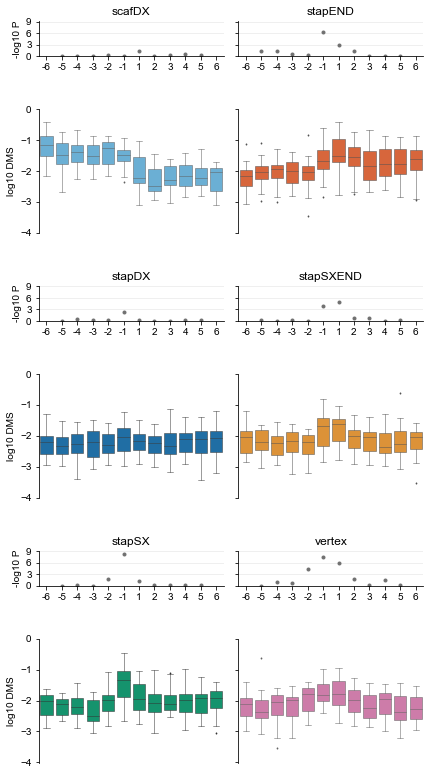

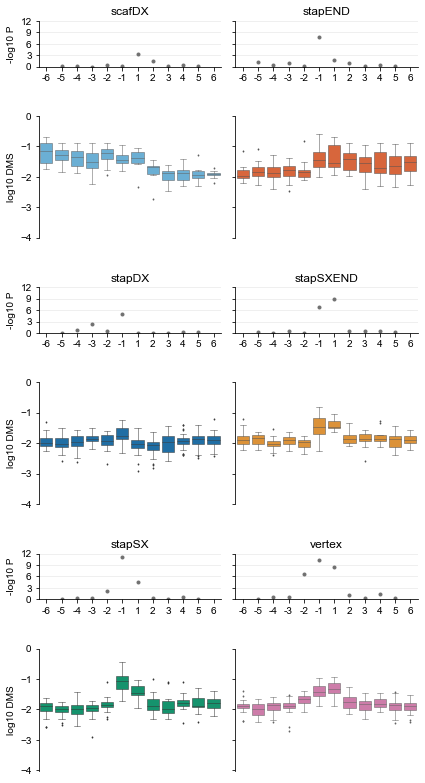

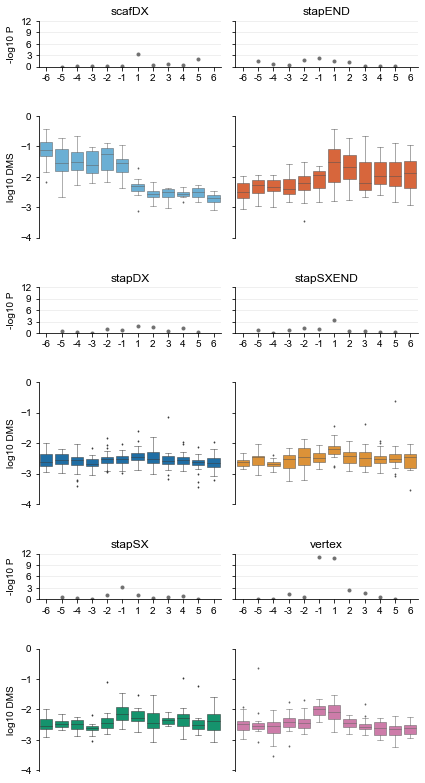

In [12]:
# Compute the mean DMS signal at each position upstream and downstream of each feature.
features_dms = dict()
features_dms_p = dict()
range_up = 6
range_dn = 6

for base in "MAC":
    features_dms[base] = dict()
    features_dms_p[base] = dict()
    for index in origami_segment_bases.index:
        origami, pos = index
        dms = origami_segment_bases.loc[index, dms_col]
        if np.isnan(dms):
            continue
        if base == "M" or base == origami_segment_bases.loc[index, base_col]:
            feat5 = tidy_feature(origami_segment_bases.loc[index, "Feature5"])
            feat3 = tidy_feature(origami_segment_bases.loc[index, "Feature3"])
            seg5 = origami_segment_bases.loc[index, "Seg5"]
            seg3 = origami_segment_bases.loc[index, "Seg3"]
            pos_up = pos - seg3 - 1  # position upstream from 3' feature
            assert pos_up <= -1
            pos_dn = pos - seg5 + 1  # position downstream from 5' feature
            assert pos_dn >= 1
            if pos_up >= -range_up:
                # add DMS signal to list at the position upstream of the 3' feature
                if feat3 not in features_dms[base]:
                    features_dms[base][feat3] = list()
                features_dms[base][feat3].append(
                    {"Position": pos_up, "DMS": dms, "logDMS": np.log10(dms)})
            if pos_dn <= range_dn:
                # add DMS signal to list at the position downstream of the 5' feature
                if feat5 not in features_dms[base]:
                    features_dms[base][feat5] = list()
                features_dms[base][feat5].append(
                    {"Position": pos_dn, "DMS": dms, "logDMS": np.log10(dms)})
    # convert each feature entry to a DataFrame
    for feat_i, feat in enumerate(feature_names):
        features_dms[base][feat] = pd.DataFrame.from_records(features_dms[base][feat])
    
    # compute p-values that medians on each side of the feature are equal
    for feat in feature_names:
        features_dms_p[base][feat] = dict()
        for p_pos in range(-range_up + 1, 0):
            dms_up = features_dms[base][feat]["DMS"].loc[
                features_dms[base][feat]["Position"] < p_pos]
            dms_pos = features_dms[base][feat]["DMS"].loc[
                features_dms[base][feat]["Position"] == p_pos]
            u, pval = mannwhitneyu(dms_pos, dms_up, alternative="greater")
            features_dms_p[base][feat][p_pos] = pval
        for p_pos in range(1, range_dn):
            dms_dn = features_dms[base][feat]["DMS"].loc[
                features_dms[base][feat]["Position"] > p_pos]
            dms_pos = features_dms[base][feat]["DMS"].loc[
                features_dms[base][feat]["Position"] == p_pos]
            u, pval = mannwhitneyu(dms_pos, dms_dn, alternative="greater")
            features_dms_p[base][feat][p_pos] = pval
        
    # box plot of logDMS reactivities and p-values
    nrows, ncols = 3, 2
    assert len(feature_names) == nrows * ncols
    fig, axs = plt.subplots(nrows=nrows*2, ncols=ncols, sharex=False, sharey=False)
    for feat_i, feat in enumerate(feature_names):
        i_col, i_row = divmod(feat_i, nrows)
        
        # logDMS reactivities
        ax_dms = axs[i_row * 2 + 1, i_col]
        sns.boxplot(data=features_dms[base][feat], x="Position", y="logDMS", ax=ax_dms,
                   linewidth=0.5, fliersize=1.0, color=tidy_colors[feat])
        ax_dms.set_ylim(-4.01, 0.0)
        ax_dms.set_xlabel("")
        ax_dms.set_yticks(np.linspace(-4.0, 0.0, 5))
        if i_col == 0:
            ax_dms.set_ylabel("log10 DMS")
        else:
            ax_dms.set_ylabel("")
            ax_dms.set_yticklabels([])
        ax_dms.spines["top"].set(visible=False)
        ax_dms.spines["bottom"].set(visible=False)
        ax_dms.spines["right"].set(visible=False)
        ax_dms.xaxis.tick_top()
        ax_dms.set_aspect(2.0)
        
        # logP-values
        ax_pvl = axs[i_row * 2, i_col]
        pos = np.array(list(features_dms_p[base][feat].keys()))
        neglogp = -np.log10(list(features_dms_p[base][feat].values()))
        print(feat, "-log10 P", neglogp)
        p_pos = pos - pos[0] + (pos < 0)
        ax_pvl.scatter(p_pos, neglogp, c="#707070", s=9.0)
        ax_pvl.set_xticks(ax_dms.get_xticks())
        ax_pvl.set_xticklabels(np.hstack([[pos[0] - 1], pos, [pos[-1] + 1]]))
        ax_pvl.set_ylim(0.0, 9.1)
        if base == "M":
            ax_pvl.set_yticks(np.linspace(0.0, 9.0, 4))
        else:
            ax_pvl.set_yticks(np.linspace(0.0, 12.0, 5))
        if i_col == 0:
            ax_pvl.set_ylabel("-log10 P")
        else:
            ax_pvl.set_ylabel("")
            ax_pvl.set_yticklabels([])
        ax_pvl.spines["top"].set(visible=False)
        ax_pvl.spines["right"].set(visible=False)
        #ax_pvl.spines["bottom"].set(visible=False)
        ax_pvl.set_aspect(0.25)
        
        x_min = p_pos[0] - 1.5
        x_max = p_pos[-1] + 1.5
        ax_dms.set_xlim(x_min, x_max)
        ax_pvl.set_xlim(x_min, x_max)
        ax_dms.set_xticks([])
        #ax_dms.set_xticklabels([])
        ax_pvl.set_title(feat)
        
        # Add grid lines underneath the other plot elements (zorder=0)
        for y in ax_pvl.get_yticks()[1:]:
            ax_pvl.plot([x_min, x_max], [y, y], color="#e0e0e0", zorder=0, linewidth=0.5)
        #for y in ax_dms.get_yticks():
        #    ax_dms.plot([x_min, x_max], [y, y], color="#e8e8e8", zorder=0)
        
    fig.set_size_inches(ncols * 3.0, nrows * 3.8)
    plt.tight_layout()
    plt.savefig(f"features_dms_{base}.pdf")


In [13]:
origami_segments = pd.concat(list(origami_segments.values()), axis=0, ignore_index=True)
origami_segments.to_csv("origami_segments.tsv", sep="\t")
origami_segments

,Seg5,Seg3,Feature5,Feature3,Origami,Length,DMS5M,DMS3M,DMS5aM,DMS3aM,...,DMSallA,DMSintA,DMS5C,DMS3C,DMS5aC,DMS3aC,DMSallC,DMSintC,GC,Tm
0,1,16,scaf_scafEND5_0,scaf_stapDX_5,rPB66v2,16,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.687500,67.164076
1,17,38,scaf_stapDX_3,scaf_stapDX_5,rPB66v2,22,NaN,NaN,NaN,0.002606,...,0.008109,0.008109,NaN,NaN,NaN,0.002606,0.002470,0.002470,0.500000,58.778355
2,39,47,scaf_stapDX_3,scaf_vertex_5,rPB66v2,9,NaN,0.006940,0.006360,NaN,...,0.009777,0.009777,NaN,0.006940,0.00636,NaN,0.006644,0.006360,0.555556,21.427189
3,48,60,scaf_vertex_3,scaf_stapSXEND5_0,rPB66v2,13,NaN,0.035113,NaN,NaN,...,0.010663,0.005876,NaN,NaN,NaN,NaN,0.004008,0.004008,0.538462,44.024706
4,61,68,scaf_stapSX_3,scaf_stapEND5_0,rPB66v2,8,NaN,0.022422,0.037847,0.030708,...,0.031589,0.031589,NaN,0.022422,NaN,0.030708,0.026240,0.030708,0.375000,6.218190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
503,875,885,scaf_stapDX_3,scaf_stapEND5_0,rT77,11,0.001532,0.030514,NaN,0.015015,...,0.013599,0.011111,0.001532,NaN,NaN,NaN,0.001532,NaN,0.454545,25.013788
504,886,896,scaf_stapEND3_0,scaf_stapSX_5,rT77,11,NaN,NaN,NaN,NaN,...,0.013529,0.013529,NaN,NaN,NaN,NaN,0.007354,0.007354,0.545455,34.511402
505,897,905,scaf_stapSXEND3_0,scaf_vertex_5,rT77,9,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.666667,35.715757
506,906,918,scaf_vertex_3,scaf_stapDX_5,rT77,13,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.307692,29.241729


In [14]:
for base in "MAC":
    # For each feature, get all the segments involving the feature
    feat_logratios = dict()
    for feat in feature_names:
        feat5s = [f for f in markers5 if tidy_feature(f) == feat]
        assert len(feat5s) == 1
        feat5 = feat5s[0]
        feat3s = [f for f in colors3 if tidy_feature(f) == feat]
        assert len(feat3s) == 1
        feat3 = feat3s[0]
        interval = dict()
        for side, featside in {"5": feat5, "3": feat3}.items():
            selector = origami_segments[f"Feature{side}"] == featside
            segs_feat = origami_segments.loc[selector]
            n_segs = segs_feat.shape[0]
            if n_segs > 0:
                # Confidence interval for ratio of ends to interior - unpaired
                log_side = np.log10(segs_feat[f"DMS{side}{base}"]).dropna()
                log_int = np.log10(segs_feat[f"DMSint{base}"]).dropna()
                cm = sms.CompareMeans(sms.DescrStatsW(log_side),
                                      sms.DescrStatsW(log_int))
                interval[side] = cm.tconfint_diff(usevar="unequal")
                # Confidence interval for ratio of ends to interior - paired
                feat_logratios[feat, side] = np.log10(segs_feat[f"DMS{side}{base}"] / segs_feat[f"DMSint{base}"]).dropna()
    feat_logratios_df = pd.DataFrame.from_dict(dict(enumerate([{"Feature": f"{feat} at {side}'", "LogRatio": logratio}
            for (feat, side), logratios in feat_logratios.items() for logratio in logratios])), orient="index")
    feat_logratios_df.to_csv(f"feature_logratios_{base}.tsv", sep="\t")
    fig, axs = plt.subplots(nrows=2, ncols=1)
    ax = axs[1]
    palette = {feat: get_feature_hex(feat.split()[0])
               for feat in set(list(feat_logratios_df["Feature"]))}
    sns.swarmplot(data=feat_logratios_df, x="Feature", y="LogRatio", palette=palette, ax=ax)
    xlabels = ax.get_xticklabels()
    for x, xlabel in enumerate(xlabels):
        feat = xlabel.get_text()
        y = np.mean(feat_logratios_df.loc[feat_logratios_df["Feature"] == feat])
        ax.scatter([x], [y], marker="_", color="#404040", zorder=4)
    ax.plot([0, len(xlabels)], [0.0, 0.0], c="#aaaaaa", linestyle="--")
    ax.set_xticklabels(xlabels, rotation=90)
    ax.set_ylim(-1.0, 2.0)
    ax.set_aspect(1.8)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    # P-values for difference from 0
    feat_side_order = list(feat_logratios.keys())
    feature_diffs = pd.DataFrame(index=feat_side_order, columns=feat_side_order, dtype=float)
    feature_pvals = pd.DataFrame(index=feat_side_order, columns=feat_side_order, dtype=float)
    shapiro_pvals = dict()
    logratio_pvals = pd.Series(index=list(feat_logratios.keys()))
    for (feat, side), logratios in feat_logratios.items():
        wstat, pval = shapiro(logratios)
        shapiro_pvals[feat, side] = pval
        tstat, pval = wilcoxon(logratios, alternative="greater")
        logratio_pvals[feat, side] = pval
    logratio_pvals.to_csv(f"logratio_pvals_{base}.tsv", sep="\t")
    ax = axs[0]
    ax.scatter(np.arange(len(logratio_pvals)), -np.log10(logratio_pvals),
               c=[palette[label.get_text()] for label in axs[1].get_xticklabels()])
    ax.set_xticks([])
    ax.set_ylim(0.0, 9.0)
    ax.set_yticks(np.linspace(0.0, 9.0, 4))
    ax.set_ylabel("-log10 P-value")
    for y in ax.get_yticks():
        ax.plot(axs[1].get_xlim(), [y, y], c="#e0e0e0", zorder=0, linewidth=1.0)
    ax.set_xlim(axs[1].get_xlim())
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.set_aspect(0.15)
    fig.set_size_inches(7.0, 7.0)
    plt.tight_layout()
    plt.savefig(f"feature_logratios_{base}.pdf")
    plt.close()
    # P-value matrix
    fig, ax = plt.subplots()
    for f1, f2 in itertools.combinations(feat_logratios, 2):
        lr1 = feat_logratios[f1]
        lr2 = feat_logratios[f2]
        diff_mean = np.mean(lr2) - np.mean(lr1)
        #result = ttest_ind(lr1, lr2, equal_var=False)
        #pval = result.pvalue
        ustat, pval = mannwhitneyu(lr1, lr2)
        feature_diffs[f1][f2] = diff_mean
        feature_diffs[f2][f1] = -diff_mean
        feature_pvals[f1][f2] = pval
        feature_pvals[f2][f1] = pval
    # Heat maps
    fig, ax = plt.subplots()
    feature_order = [feat for feat, side in feat_side_order if side == "5"]
    # P-values
    heatmap_pvals = pd.DataFrame(index=feature_order, columns=feature_order, dtype=float)
    for f1, f2 in itertools.combinations(feature_order, 2):
        heatmap_pvals.loc[f1, f2] = feature_pvals[(f1, "3")][(f2, "3")]
        heatmap_pvals.loc[f2, f1] = feature_pvals[(f1, "5")][(f2, "5")]
    heatmap_pvals = np.floor(-np.log10(heatmap_pvals))
    sns.heatmap(heatmap_pvals, square=True, cmap="binary")
    plt.savefig(f"feature_pvals_{base}.pdf")
    plt.close()
    # Pairwise differences between features
    heatmap_diffs = pd.DataFrame(index=feature_order, columns=feature_order, dtype=float)
    for f1, f2 in itertools.combinations(feature_order, 2):
        heatmap_diffs.loc[f1, f2] = feature_diffs[(f2, "3")][(f1, "3")]
        heatmap_diffs.loc[f2, f1] = feature_diffs[(f2, "5")][(f1, "5")]
    sns.heatmap(heatmap_diffs, square=True, cmap="coolwarm", center=0.0)
    plt.savefig(f"feature_diffs_{base}.pdf")
    plt.close()
    for side in ["5", "3"]:
        feats_side = [(feat, s) for feat, s in feat_side_order if s == side]
        # Volcano plots
        fig, ax = plt.subplots()
        for f2, f1 in itertools.product(feats_side, repeat=2):
            diff = feature_diffs[f1][f2]
            pval = feature_pvals[f1][f2]
            # mark by feature 1, color by feature 2
            marker, color, edgecolor = get_markers(
                tidy_to_full(f1[0], "3"),
                tidy_to_full(f2[0], "5"))
            #color = edgecolor if edgecolor is not None else color
            ax.scatter([diff], [-np.log10(pval)],
                       marker=marker, c=color, edgecolor=edgecolor, s=30.0)
            ax.set_xlim(-1.0, 1.0)
            ax.set_xticks(np.linspace(-1.0, 1.0, 5))
            if base == "M":
                ymax = 6.0
            else:
                ymax = 8.0
            ax.set_ylim(0.0, ymax)
            ax.set_yticks(np.arange(0.0, ymax + 1.0, 2.0))
            ax.set_aspect(3.2 / ymax)
            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)
            ax.set_xlabel("Difference in mean log10 DMS")
            ax.set_ylabel("-log10 P-value")
            ax.plot([0, 0], [0, ymax], c="#d0d0d0", linestyle="--", zorder=0)
        plt.savefig(f"feature_volcano_{side}_{base}.pdf")
        plt.close()
    feature_diffs.to_csv(f"feature_diffs_{base}.tsv", sep="\t")
    feature_pvals.to_csv(f"feature_pvals_{base}.tsv", sep="\t")

<ipython-input-14-41aae22058f7>:49: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  logratio_pvals = pd.Series(index=list(feat_logratios.keys()))


scafDX at 5' {'A': 0.38275391788996227, 'C': 0.26111924849640117}
scafDX at 3' {'A': -0.051943492658435404, 'C': -0.16317824478165788}
stapDX at 5' {'A': -0.1601219816325127, 'C': 0.026740357992836854}
stapDX at 3' {'A': 0.1837978814508044, 'C': 0.050308027489739754}
stapSX at 5' {'A': 0.3927235759232692, 'C': 0.1319555416007928}
stapSX at 3' {'A': 0.8361157997864521, 'C': 0.2576838658979673}
stapEND at 5' {'A': 0.24504175830038077, 'C': 0.5262861174006925}
stapEND at 3' {'A': 0.46333158237334393, 'C': 0.22398307204758158}
stapSXEND at 5' {'A': 0.4733496779047258, 'C': 0.26193754637637334}
stapSXEND at 3' {'A': 0.45319276746490444, 'C': 0.16883097865428803}
vertex at 5' {'A': 0.4584242482524329, 'C': 0.5148569432746035}
vertex at 3' {'A': 0.41951501323278423, 'C': 0.4788884157955204}


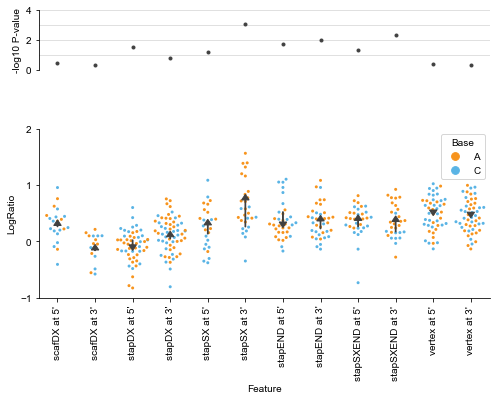

In [15]:
# Plots of ratios for both A and C together
feat_logratios = list()
bases = "AC"
for base in bases:
    fname = f"feature_logratios_{base}.tsv"
    df = pd.read_csv(fname, sep="\t")
    for feat, logratio in zip(df["Feature"], df["LogRatio"]):
        feat_logratios.append({"Feature": feat, "LogRatio": logratio, "Base": base})
feat_logratios = pd.DataFrame.from_records(feat_logratios)
feat_logratios.to_csv("feature_logratios_AC.tsv", sep="\t")
fig, axs = plt.subplots(nrows=2, ncols=1)
ax = axs[1]
sns.swarmplot(data=feat_logratios, x="Feature", y="LogRatio", hue="Base",
              palette={"A": "#f7941d", "C": "#5ab4e5"}, dodge=False, s=3.0)
xlabels = ax.get_xticklabels()
ax.set_xticklabels(xlabels, rotation=90.0)
pvals = list()
for x, label in enumerate(xlabels):
    feature = label.get_text()
    is_feature = feat_logratios.loc[feat_logratios["Feature"] == feature]
    base_data = dict()
    for base in bases:
        base_data[base] = is_feature.loc[is_feature["Base"] == base, "LogRatio"]
    ustat, pval = mannwhitneyu(base_data["A"], base_data["C"],
                               alternative="two-sided")
    pvals.append(pval)
    means = {base: np.mean(logratios) for base, logratios in base_data.items()}
    ax.arrow(x, means["C"], 0.0, means["A"] - means["C"],
             width=0.02, head_width=0.2, head_length=0.1,
             edgecolor="#404040", facecolor="#404040",
             length_includes_head=True, zorder=4)
    print(feature, means)
ax.set_ylim(-1.0, 2.0)
ax.set_yticks(np.linspace(-1.0, 2.0, 4))
ax.set_aspect(1.5)
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax = axs[0]
ax.scatter(np.arange(len(pvals)), -np.log10(pvals), c="#404040", s=9.0)
ax.set_ylim(0.0, 4.0)
ax.set_aspect(0.4)
ax.set_ylabel("-log10 P-value")
ax.spines["right"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)
for y in ax.get_yticks():
    ax.plot(axs[1].get_xlim(), [y, y], c="#e0e0e0", zorder=0, linewidth=1.0)
ax.set_xlim(axs[1].get_xlim())
ax.set_xticks([])
fig.set_size_inches(7.0, 7.0)
plt.tight_layout()
plt.savefig("feature_logratios_AC.pdf")

In [16]:
-np.log10(feature_pvals)

,"(scafDX, 5)","(scafDX, 3)","(stapDX, 5)","(stapDX, 3)","(stapSX, 5)","(stapSX, 3)","(stapEND, 5)","(stapEND, 3)","(stapSXEND, 5)","(stapSXEND, 3)","(vertex, 5)","(vertex, 3)"
"(scafDX, 5)",NaN,2.589462,1.825815,1.580102,0.930919,0.354766,1.332999,0.655745,0.460358,0.982836,1.948238,1.772257
"(scafDX, 3)",2.589462,NaN,1.119190,1.393805,0.874100,2.313995,2.813850,2.132597,2.831747,1.852199,3.608492,3.954256
"(stapDX, 5)",1.825815,1.119190,NaN,0.489781,0.474537,1.694505,3.525661,1.380633,2.558350,0.823153,5.376843,5.421330
"(stapDX, 3)",1.580102,1.393805,0.489781,NaN,0.301030,1.506254,3.492342,1.048489,2.176293,0.561051,5.271766,5.592920
"(stapSX, 5)",0.930919,0.874100,0.474537,0.301030,NaN,0.945899,2.026708,0.849788,1.043219,0.774152,2.428297,2.470103
"(stapSX, 3)",0.354766,2.313995,1.694505,1.506254,0.945899,NaN,1.244499,0.684058,0.460527,1.153462,1.825240,1.486894
"(stapEND, 5)",1.332999,2.813850,3.525661,3.492342,2.026708,1.244499,NaN,1.763850,1.368935,1.971941,0.437209,0.458603
"(stapEND, 3)",0.655745,2.132597,1.380633,1.048489,0.849788,0.684058,1.763850,NaN,0.929688,0.485345,2.486659,2.766005
"(stapSXEND, 5)",0.460358,2.831747,2.558350,2.176293,1.043219,0.460527,1.368935,0.929688,NaN,1.462075,2.148482,1.606537
"(stapSXEND, 3)",0.982836,1.852199,0.823153,0.561051,0.774152,1.153462,1.971941,0.485345,1.462075,NaN,2.594131,3.100822


In [17]:
feat_logratios

,Feature,LogRatio,Base
0,scafDX at 5',-0.139226,A
1,scafDX at 5',0.625425,A
2,scafDX at 5',0.360121,A
3,scafDX at 5',0.391687,A
4,scafDX at 5',0.758542,A
...,...,...,...
422,vertex at 3',0.963079,C
423,vertex at 3',0.185171,C
424,vertex at 3',0.627064,C
425,vertex at 3',0.349416,C


Length vs GC
	PCC: (0.0541281039230613, 0.223272190816123)
	SRC: SpearmanrResult(correlation=0.059770936925990246, pvalue=0.17860823833148898)
Length vs Tm
	PCC: (0.8169455539673298, 4.823335368303654e-123)
	SRC: SpearmanrResult(correlation=0.8720436401633758, pvalue=3.9033541663751055e-159)


<ipython-input-21-445048460fd8>:30: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.scatter(x + x_jitter, y, s=16.0, marker=marker, c=color, edgecolors=edgecolor)
<ipython-input-21-445048460fd8>:37: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.scatter(seg_length_dms_means.index, seg_length_dms_means, c="black", marker="_")


Length vs DMSintM
	PCC: (-0.4179424712153963, 3.878670012315878e-22)
	SRC: SpearmanrResult(correlation=-0.40894407322308923, pvalue=3.539854688005599e-21)
GC vs Tm
	PCC: (0.47378710444178007, 8.689809700200798e-30)
	SRC: SpearmanrResult(correlation=0.45915869679749644, pvalue=7.398705125765128e-28)


<ipython-input-21-445048460fd8>:30: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.scatter(x + x_jitter, y, s=16.0, marker=marker, c=color, edgecolors=edgecolor)


GC vs DMSintM
	PCC: (-0.3654536501563791, 6.276823760045301e-17)
	SRC: SpearmanrResult(correlation=-0.4130869813126706, pvalue=1.2896255922055049e-21)
Tm vs DMSintM
	PCC: (-0.6780317461638898, 3.0398286316813876e-67)
	SRC: SpearmanrResult(correlation=-0.5836871098562774, pvalue=4.4402090221361836e-46)
Length vs GC
	PCC: (0.0541281039230613, 0.223272190816123)
	SRC: SpearmanrResult(correlation=0.059770936925990246, pvalue=0.17860823833148898)
Length vs Tm
	PCC: (0.8169455539673298, 4.823335368303654e-123)
	SRC: SpearmanrResult(correlation=0.8720436401633758, pvalue=3.9033541663751055e-159)


<ipython-input-21-445048460fd8>:37: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.scatter(seg_length_dms_means.index, seg_length_dms_means, c="black", marker="_")


Length vs DMSintA
	PCC: (-0.32133804842688973, 2.8746899993192063e-12)
	SRC: SpearmanrResult(correlation=-0.30906579989897986, pvalue=2.0440614703137912e-11)
GC vs Tm
	PCC: (0.47378710444178007, 8.689809700200798e-30)
	SRC: SpearmanrResult(correlation=0.45915869679749644, pvalue=7.398705125765128e-28)


<ipython-input-21-445048460fd8>:30: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.scatter(x + x_jitter, y, s=16.0, marker=marker, c=color, edgecolors=edgecolor)


GC vs DMSintA
	PCC: (-0.10510015561166663, 0.02578146466637718)
	SRC: SpearmanrResult(correlation=-0.002608929214661689, pvalue=0.955987166865671)
Tm vs DMSintA
	PCC: (-0.38641424934205987, 1.7855207412242585e-17)
	SRC: SpearmanrResult(correlation=-0.20090158220847612, pvalue=1.7566610386510573e-05)
Length vs GC
	PCC: (0.0541281039230613, 0.223272190816123)
	SRC: SpearmanrResult(correlation=0.059770936925990246, pvalue=0.17860823833148898)
Length vs Tm
	PCC: (0.8169455539673298, 4.823335368303654e-123)
	SRC: SpearmanrResult(correlation=0.8720436401633758, pvalue=3.9033541663751055e-159)


<ipython-input-21-445048460fd8>:37: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.scatter(seg_length_dms_means.index, seg_length_dms_means, c="black", marker="_")


Length vs DMSintC
	PCC: (-0.4482109869247048, 6.20650130297622e-23)
	SRC: SpearmanrResult(correlation=-0.4728256435871642, pvalue=1.142269937617385e-25)
GC vs Tm
	PCC: (0.47378710444178007, 8.689809700200798e-30)
	SRC: SpearmanrResult(correlation=0.45915869679749644, pvalue=7.398705125765128e-28)


<ipython-input-21-445048460fd8>:30: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.scatter(x + x_jitter, y, s=16.0, marker=marker, c=color, edgecolors=edgecolor)


GC vs DMSintC
	PCC: (-0.13799084721664182, 0.003890773304863502)
	SRC: SpearmanrResult(correlation=-0.12256407919779391, pvalue=0.01042121327096838)
Tm vs DMSintC
	PCC: (-0.5935616752501638, 7.473992237600637e-43)
	SRC: SpearmanrResult(correlation=-0.45949256442410036, pvalue=3.68802109254401e-24)


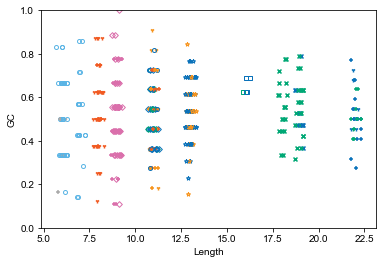

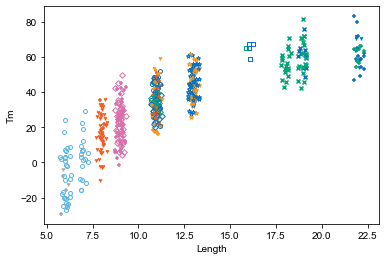

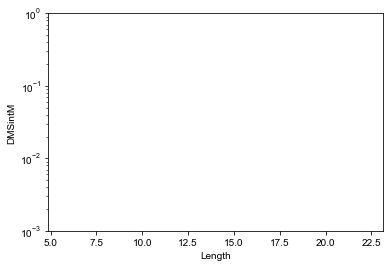

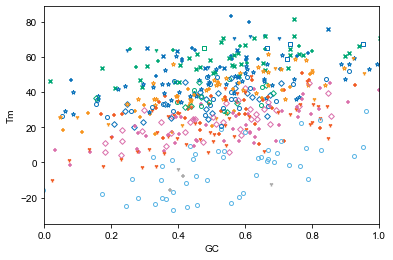

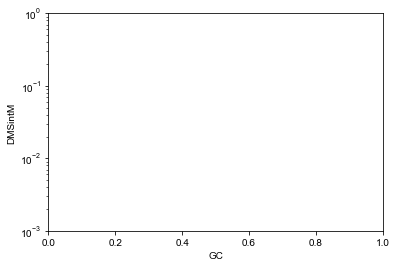

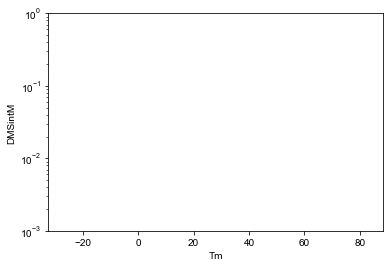

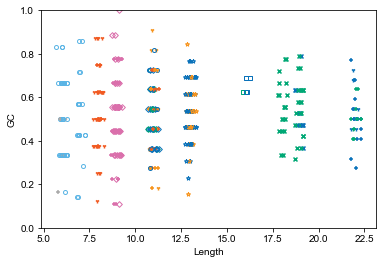

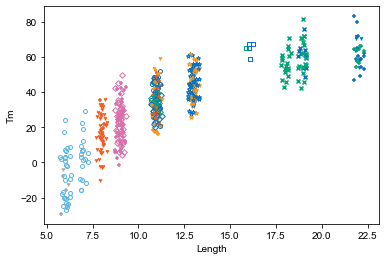

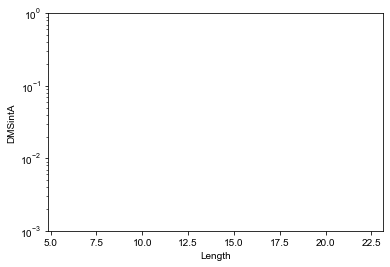

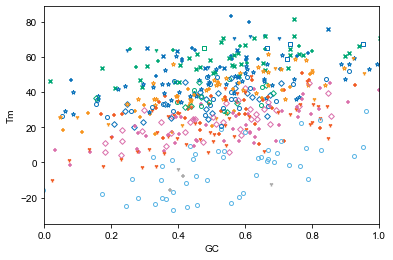

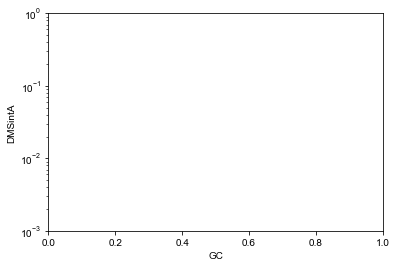

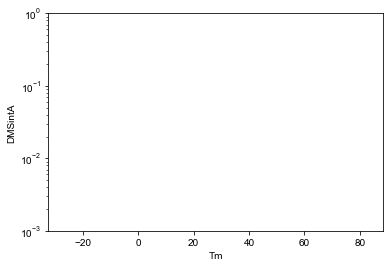

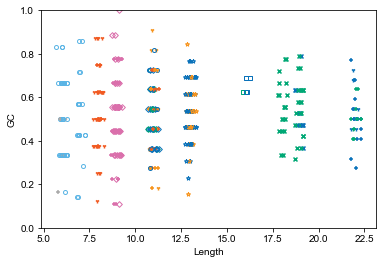

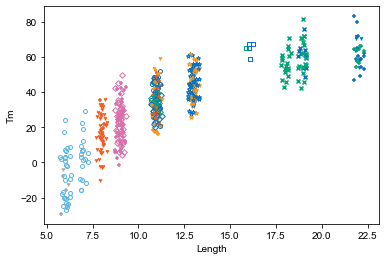

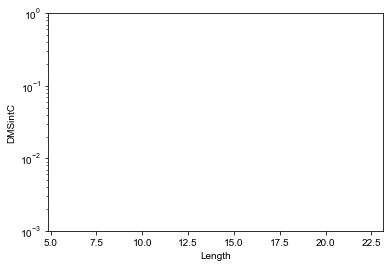

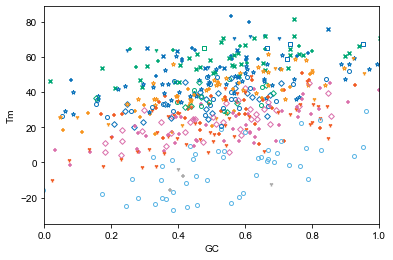

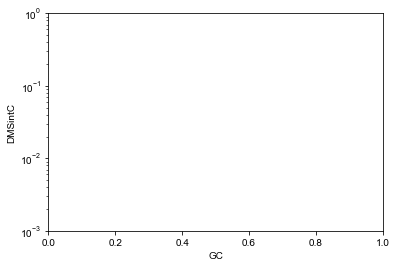

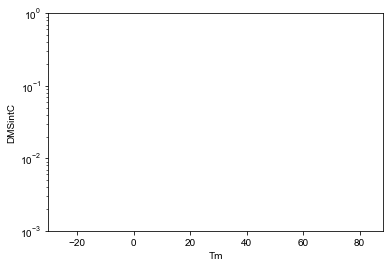

In [21]:
for base in "MAC":
    # Plots of two variables at a time
    for p1, p2 in itertools.combinations(
        ["Length", "GC", "Tm", f"DMSint{base}"], 2):
        np.random.seed(0)
        labels = set()
        fig, ax = plt.subplots()
        xs = list()
        ys = list()
        for seg in origami_segments.index:
            x = origami_segments.loc[seg, p1]
            y = origami_segments.loc[seg, p2]
            if "DMS" in p2:
                y = np.log10(y)
            xs.append(x)
            ys.append(y)
            x_jitter = np.random.randn() * jitter_std
            if x_jitter > 0:
                x_jitter = min(x_jitter, jitter_max)
            else:
                x_jitter = max(x_jitter, -jitter_max)
            if "DMS" in p1:
                ax.set_xscale("log")
            if "DMS" in p2:
                ax.set_yscale("log")
            label = None
            f5 = origami_segments.loc[seg, "Feature5"]
            f3 = origami_segments.loc[seg, "Feature3"]
            marker, color, edgecolor = get_markers(f5, f3)
            ax.scatter(x + x_jitter, y, s=16.0, marker=marker, c=color, edgecolors=edgecolor)
        # add means
        lengths = sorted(set(origami_segments["Length"]))
        if p1 == "Length" and "DMS" in p2:
            seg_length_dms_means = pd.Series({length: np.log10(origami_segments.loc[
                origami_segments["Length"] == length, p2]).mean()
                for length in lengths})
            ax.scatter(seg_length_dms_means.index, seg_length_dms_means, c="black", marker="_")
        ax.set_xlabel(p1)
        ax.set_ylabel(p2)
        xs = np.asarray(xs)
        ys = np.asarray(ys)
        use = [not (np.isnan(x) or np.isnan(y)) for x, y in zip(xs, ys)]
        r = pearsonr(xs[use], ys[use])
        rho = spearmanr(xs[use], ys[use])
        print(p1, "vs", p2)
        print("\tPCC:", r)
        print("\tSRC:", rho)
        if p1 == "GC":
            ax.set_xlim((0.0, 1.0))
        elif p1 == "length":
            ax.set_xlim((6, 24))
            ax.set_xticks(list(range(6, 24 + 1, 2)))
        if p2 == "GC":
            ax.set_ylim((0.0, 1.0))
        elif "DMS" in p2:
            ax.set_ylim((1e-3, 1e0))
        plt.savefig(f"segment_data_{p1}_{p2}.pdf")
